In [1008]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from datetime import datetime
from scipy.stats import chi2_contingency
import plotly.graph_objects as go

#### Loading data by splitting the dataset into multiple chunks of 200,000 rows each.

In [1012]:
steam_review_df = pd.read_csv('steam_reviews.csv',sep=",", header='infer', index_col=0, chunksize=200000) 

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    
is_first_chunk = True

num_isnull_df=pd.DataFrame()
df_size=0
app_name_df=pd.DataFrame()
language_df=pd.DataFrame()
author_df=pd.DataFrame()
author_playtime_forever_df=pd.DataFrame()
author_playtime_at_review_df=pd.DataFrame()
num_review_df=pd.DataFrame()
monthly_num_review_df=pd.DataFrame()
seasonal_num_review_df=pd.DataFrame()
month_day_num_review_df=pd.DataFrame()
time_num_review_df=pd.DataFrame()
date_time_df=pd.DataFrame()
player_game_playtime_df=pd.DataFrame()
player_preference_df=pd.DataFrame()

for chunk in steam_review_df: 
    #Some information does not require exploring the entire dataset
    if is_first_chunk:    
        df_head=chunk.head()
        df_dtypes=chunk.dtypes

    is_first_chunk = False
    
    num_isnull_df=pd.concat([num_isnull_df,chunk.isnull()])
    df_size+=chunk.shape[0]
    app_name_df=pd.concat([app_name_df,chunk['app_name']])
    language_df=pd.concat([language_df,chunk['language']])
    author_df=pd.concat([author_df,chunk['author.steamid']])
    author_playtime_forever_df=pd.concat([author_playtime_forever_df,chunk['author.playtime_forever']])
    author_playtime_at_review_df=pd.concat([author_playtime_at_review_df,chunk['author.playtime_at_review']])
    
    chunk['datetime_created']=pd.to_datetime(chunk['timestamp_created'], unit='s')
    chunk['month_created']=pd.to_datetime(chunk['timestamp_created'], unit='s').dt.month
    chunk['day_created']=pd.to_datetime(chunk['timestamp_created'], unit='s').dt.day
    chunk['month_day_created']=chunk['month_created'].astype(str)+"/"+chunk['day_created'].astype(str)
    chunk['season_created']=chunk['month_created'].apply(get_season)
    chunk['time_created']=pd.to_datetime(chunk['timestamp_created'], unit='s').dt.strftime('%H:%M')
    #A user is considered a veteran user of a game if their gameplay time exceeds one month
    chunk['seniority']=['new user' if playtime < 43200 else 'veteran user' for playtime in chunk['author.playtime_forever']]
    
    num_review_df=pd.concat([num_review_df,chunk.groupby('app_name').agg(num_review=('review_id','count'),
                                                                         num_purchased=('steam_purchase','sum'),
                                                                         num_received_free=('received_for_free','sum'),
                                                                         num_recommended=('recommended','sum')
                                                                        ).reset_index()],ignore_index=True)
    monthly_num_review_df=pd.concat([monthly_num_review_df,chunk.groupby(['app_name', 'month_created']).agg(
                                                                        num_review=('review_id','count')
                                                                        ).reset_index()],ignore_index=True)

    seasonal_num_review_df=pd.concat([seasonal_num_review_df,chunk.groupby(['app_name', 'season_created']).agg(
                                                                        num_review=('review_id','count')
                                                                        ).reset_index()],ignore_index=True)
    month_day_num_review_df=pd.concat([month_day_num_review_df,chunk.groupby(['app_name', 'month_day_created']).agg(
                                                                        num_review=('review_id','count')
                                                                        ).reset_index()],ignore_index=True)
    time_num_review_df=pd.concat([time_num_review_df,chunk.groupby(['app_name','time_created']).agg(
                                                                        num_review=('review_id','count')
                                                                        ).reset_index()],ignore_index=True)
    date_time_df=pd.concat([date_time_df,chunk['datetime_created']])
    player_game_playtime_df=pd.concat([player_game_playtime_df,chunk.groupby(['author.steamid','app_name']).agg(
                                                                        playtime=('author.playtime_forever','max')
                                                                        ).reset_index()],ignore_index=True)
    
    player_preference_df=pd.concat([player_preference_df,chunk[['author.playtime_forever','recommended','seniority']]])



# Research questions (RQs)

1. [**RQ1**] Before diving deep into the dataset provided, it's crucial to understand its structure and main features. Data scientists usually take the first step of performing an Exploratory Data Analysis (EDA). What can you say about our dataset? Please perform an EDA and summarize the dataset's key characteristics using visualizations and tabular summaries.


In [1015]:

print("Starting Exploratory Data Analysis\n\n")
print("Printing the dataset's head\n\n")
display(df_head)
print("\n\n")
print("Printing all columns and their data types \n\n")
print(df_dtypes)
print("\n\n")
print("Printing number of null values in each column \n\n")
display(num_isnull_df.sum())
print("\n\n")
print("Printing number of records: ",df_size," \n\n")
print("Printing the number of distinct values for the most important fields: \n\n")
print(app_name_df.nunique())
print(language_df.nunique())
print(author_df.nunique())
print("\n\n")
print("Printing the mean value of author.playtime_forever \n\n")
print(int(author_playtime_forever_df['author.playtime_forever'].mean()))
print("\n\n")
print("Printing the median value of author.playtime_forever \n\n")
print(int(author_playtime_forever_df['author.playtime_forever'].median()))
print("\n\n")
print("Printing the mean value of author.playtime_at_review \n\n")
print(int(author_playtime_at_review_df['author.playtime_at_review'].mean()))
print("\n\n")
print("Printing the median value of author.playtime_at_review \n\n")
print(int(author_playtime_at_review_df['author.playtime_at_review'].median()))
print("\n\n")


Starting Exploratory Data Analysis


Printing the dataset's head




,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,1611381629,1611381629,True,0,0,...,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,1.611343e+09
1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,1611381030,1611381030,True,0,0,...,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,1.611386e+09
2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,1611380800,1611380800,True,0,0,...,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,1.611384e+09
3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970,1611379970,True,0,0,...,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09
4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,1611379427,1611379427,True,0,0,...,True,False,False,76561199028326951,7,4,217.0,42.0,217.0,1.610788e+09





Printing all columns and their data types 


app_id                              int64
app_name                           object
review_id                           int64
language                           object
review                             object
timestamp_created                   int64
timestamp_updated                   int64
recommended                          bool
votes_helpful                       int64
votes_funny                         int64
weighted_vote_score               float64
comment_count                       int64
steam_purchase                       bool
received_for_free                    bool
written_during_early_access          bool
author.steamid                      int64
author.num_games_owned              int64
author.num_reviews                  int64
author.playtime_forever           float64
author.playtime_last_two_weeks    float64
author.playtime_at_review         float64
author.last_played                float64
dtype: object



Printing nu

app_id                                0
app_name                              0
review_id                             0
language                              0
review                            33748
timestamp_created                     0
timestamp_updated                     0
recommended                           0
votes_helpful                         0
votes_funny                           0
weighted_vote_score                   0
comment_count                         0
steam_purchase                        0
received_for_free                     0
written_during_early_access           0
author.steamid                        0
author.num_games_owned                0
author.num_reviews                    0
author.playtime_forever               2
author.playtime_last_two_weeks        2
author.playtime_at_review         25682
author.last_played                    2
dtype: int64




Printing number of records:  21747371  


Printing the number of distinct values for the most important fields: 


app_name    315
dtype: int64
language    28
dtype: int64
author.steamid    10715340
dtype: int64



Printing the mean value of author.playtime_forever 


16091



Printing the median value of author.playtime_forever 


4307



Printing the mean value of author.playtime_at_review 


8807



Printing the median value of author.playtime_at_review 


1881





From the previous analysis, we explored the main characteristics of the dataset. We observed its initial records, giving us an overview of the data it contains, and we understood that each record represents a unique review submitted by a specific player.

Next, we analyzed the dataset’s columns and their respective data types. There are 22 columns (one fewer than what is seen on Kaggle, which has 23 columns, as the index column is not included). The main data types are int64, object, float64, and bool.

Then, we moved on to detecting the number of null values in each column. We observed that there isn’t a significant percentage of null values; only the review field and some playtime fields contain null values. Since Steam allows empty comments, it’s acceptable for this field to be null. Furthermore, playtime fields depend on the players' playtime. Therefore, we can conclude that all records are consistent.

We also determined the exact number of records, which is 21747371. It’s important to know the number of distinct values in some key fields:
- app_name: 315 distinct values
- language: 28 distinct values
- author.steamid: 10715340 distinct values

Finally, we examined the median and mean values of the fields author.playtime_forever and author.playtime_at_review to understand, on average, how much time users spend on a game and how long they play before leaving a review.


2. [**RQ2**] *Let's explore the dataset by analyzing the distribution of reviews across different applications.*

 - Identify which applications have the highest and lowest number of reviews.

In [1021]:
num_review_df=num_review_df.groupby('app_name').agg(num_review=('num_review','sum'),
                                                    num_purchased=('num_purchased','sum'),
                                                    num_received_free=('num_received_free','sum'),
                                                    num_recommended=('num_recommended','sum')                                                    
                                                   ).reset_index().sort_values(by='num_review', ascending=False)
print(num_review_df.loc[num_review_df['num_review'].idxmax()])
print(num_review_df.loc[num_review_df['num_review'].idxmin()])


app_name             PLAYERUNKNOWN'S BATTLEGROUNDS
num_review                                 1644255
num_purchased                              1372721
num_received_free                            61443
num_recommended                             886417
Name: 182, dtype: object
app_name             Neon Hardcorps
num_review                      200
num_purchased                    29
num_received_free                27
num_recommended                  89
Name: 164, dtype: object


The application <strong>PLAYERUNKNOWN'S BATTLEGROUNDS</strong> has the highest number of reviews, with <strong>1644255</strong> reviews,
while <strong>Neon Hardcorps</strong> has the lowest number of reviews, with <strong>200</strong> reviews.

- Plot the number of reviews for each application in descending order. What insights can you draw from the plot?

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 20256 (\N{CJK UNIFIED IDEOGRAPH-4F20}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from current font.

/opt/anaconda3/lib/python3.12/

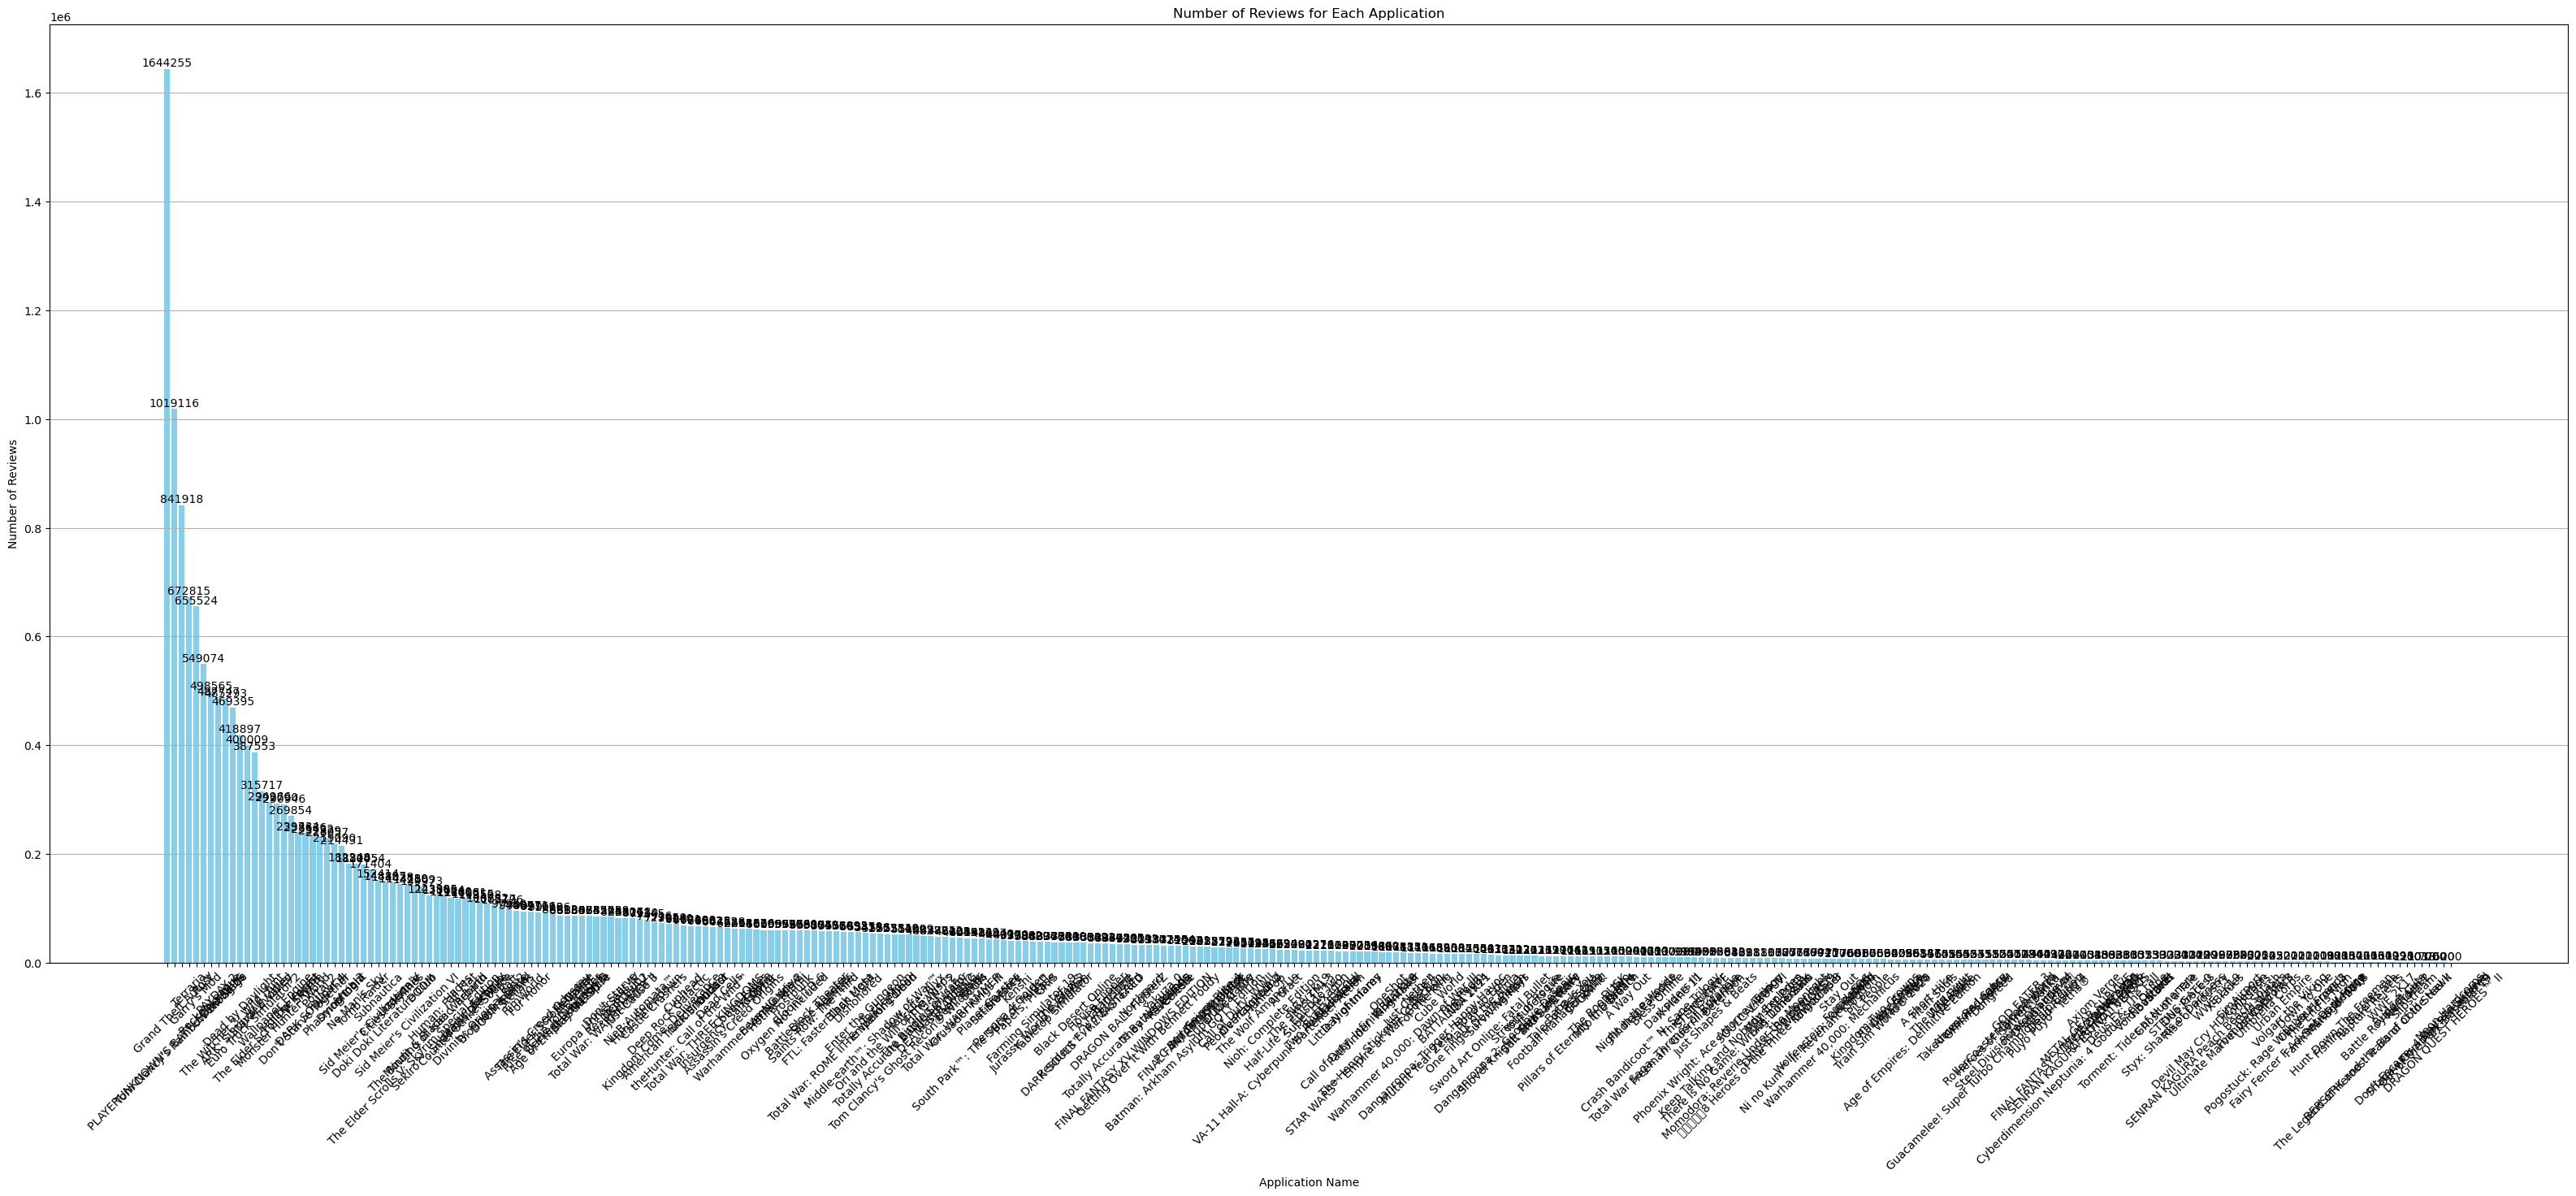

In [1025]:
plt.figure(figsize=(40,15))
bars = plt.bar(num_review_df['app_name'], num_review_df['num_review'], color='skyblue')
plt.xlabel('Application Name')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Each Application')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adding data values on top of the bars
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')  # Add text

plt.show() 

From the plot, we observe that the leading games have a significantly larger number of reviews, indicating the popularity of these games.

- For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities.


In [1029]:
top_5_app_df = num_review_df.nlargest(5, 'num_review')
top_5_app_sum_df=top_5_app_df.sum()
display(top_5_app_sum_df)
top_5_app_df['num_purchased_ratio']=np.multiply(np.divide (top_5_app_df['num_purchased'],top_5_app_df['num_review']),100).apply(lambda x: "{:.2f}%".format(x))
top_5_app_df['num_received_free_ratio']=np.multiply(np.divide(top_5_app_df['num_received_free'],top_5_app_df['num_review']),100).apply(lambda x: "{:.2f}%".format(x))
display(top_5_app_df)

app_name             PLAYERUNKNOWN'S BATTLEGROUNDSGrand Theft Auto ...
num_review                                                     4833628
num_purchased                                                  4059526
num_received_free                                               181286
num_recommended                                                3751424
dtype: object

,app_name,num_review,num_purchased,num_received_free,num_recommended,num_purchased_ratio,num_received_free_ratio
182,PLAYERUNKNOWN'S BATTLEGROUNDS,1644255,1372721,61443,886417,83.49%,3.74%
118,Grand Theft Auto V,1019116,905288,38624,831311,88.83%,3.79%
273,Tom Clancy's Rainbow Six Siege,841918,702505,36300,742397,83.44%,4.31%
248,Terraria,672815,527762,20154,658741,78.44%,3.00%
114,Garry's Mod,655524,551250,24765,632558,84.09%,3.78%


From the analysis, we observe that 4059526 reviews came from users who purchased the application, while 181286 reviews were from users who received it for free. This represents approximately 80% of reviews from purchasing users and about 4% from free users. Additionally, all five applications exhibit a similar pattern, with a high percentage of reviews coming from users who purchased the application, indicating that purchased users are generally more likely to leave reviews.

- Which applications have the most and the least user recommendations? Summarize your findings.

In [1033]:
print(num_review_df.loc[num_review_df['num_recommended'].idxmax()])
print(num_review_df.loc[num_review_df['num_recommended'].idxmin()])

app_name             PLAYERUNKNOWN'S BATTLEGROUNDS
num_review                                 1644255
num_purchased                              1372721
num_received_free                            61443
num_recommended                             886417
Name: 182, dtype: object
app_name             Neon Hardcorps
num_review                      200
num_purchased                    29
num_received_free                27
num_recommended                  89
Name: 164, dtype: object


According to the previous analysis, apps <strong>PLAYERUNKNOWN'S BATTLEGROUNDS</strong> have the highest number of user recommendations, with <strong>886417</strong> recommendations. On the other hand, app <strong>Neon Hardcorps</strong> has the fewest recommendations, with only <strong>89</strong> recommendations.

- Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.

Since the review score does not exist in the dataset, we considered it as the ratio between the number of recommendations and the number of reviews, represented on a scale from 0 to 10.

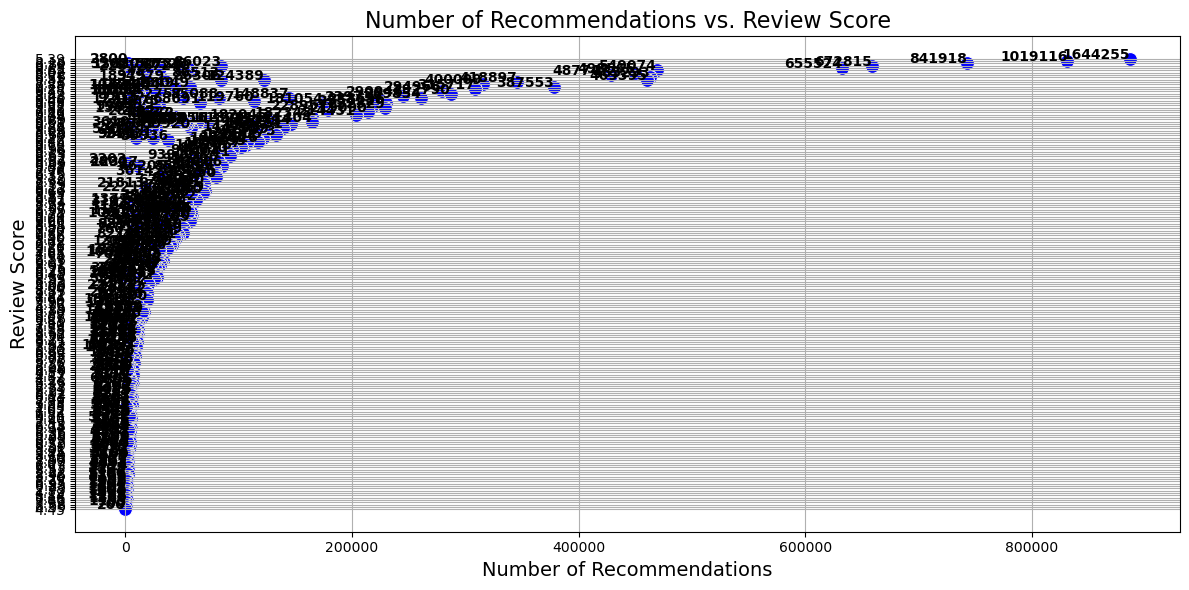

In [1038]:
num_review_df['review_score']=np.multiply(np.divide(num_review_df['num_recommended'],num_review_df['num_review']),10).apply(lambda x: "{:.2f}".format(x))

plt.figure(figsize=(12, 6))
sns.scatterplot(data=num_review_df, x='num_recommended', y='review_score', s=100, color='blue')
for i in range(num_review_df.shape[0]):
    plt.text(num_review_df['num_recommended'].iloc[i], 
             num_review_df['review_score'].iloc[i], 
             f"{num_review_df['num_review'].iloc[i]}",
             horizontalalignment='right', 
             size='medium', 
             color='black', 
             weight='semibold')


plt.title('Number of Recommendations vs. Review Score', fontsize=16)
plt.xlabel('Number of Recommendations', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

Since the review score of an application is the ratio between the number of recommendations and the total number of reviews, a higher number of recommendations will imply a higher review score. However, there are cases of high review scores with a low number of reviews; in such cases, these scores are less significant due to the limited number of examples.

3. [**RQ3**] *Understanding when users are most active in submitting reviews can help identify peak engagement periods.*

 - Plot the number of reviews submitted each month and describe any trends.

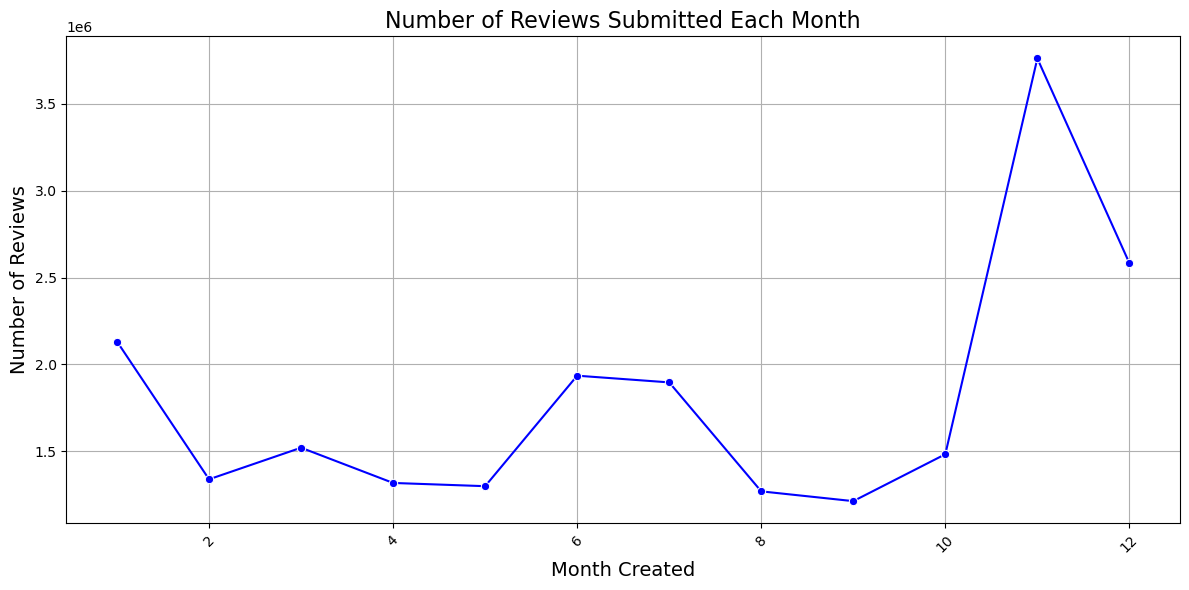

In [1043]:
monthly_num_review_df=monthly_num_review_df.groupby(['month_created']).agg(num_review=('num_review','sum')
                                                   ).reset_index().sort_values(by='num_review', ascending=False)
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_num_review_df, x='month_created', y='num_review', marker='o', color='blue')

# Set titles and labels
plt.title('Number of Reviews Submitted Each Month', fontsize=16)
plt.xlabel('Month Created', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

From the plot, we observe that the number of reviews is highest in November and December, while it dips in other months. This trend suggests that users are more active in leaving reviews during the winter months, possibly due to spending more time indoors or engaging more with apps during this period.

  - Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.

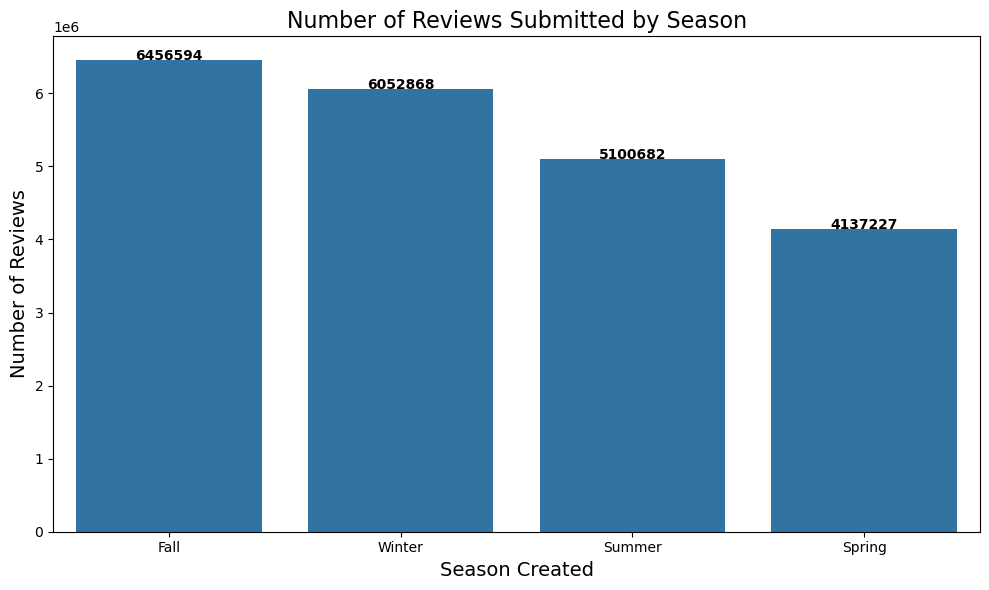

In [1047]:
seasonal_num_review_df=seasonal_num_review_df.groupby(['season_created']).agg(num_review=('num_review','sum')
                                                   ).reset_index().sort_values(by='num_review', ascending=False)
plt.figure(figsize=(10, 6))

sns.barplot(data=seasonal_num_review_df, x='season_created', y='num_review')

plt.title('Number of Reviews Submitted by Season', fontsize=16)
plt.xlabel('Season Created', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)

# Add data labels on top of each bar
for i in range(seasonal_num_review_df.shape[0]):
    plt.text(i, seasonal_num_review_df['num_review'].iloc[i], 
             f"{seasonal_num_review_df['num_review'].iloc[i]}",
             horizontalalignment='center', 
             size='medium', 
             color='black', 
             weight='semibold')

plt.tight_layout()
plt.show()

As shown in the previous chart, review activity tends to peak in the fall months while dropping off during the spring. This seasonal pattern suggests that users may be more likely to engage with apps and leave reviews during the colder months. In contrast, the lower review activity in the spring could indicate that users are spending less time on their devices, possibly due to outdoor activities.

- Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.

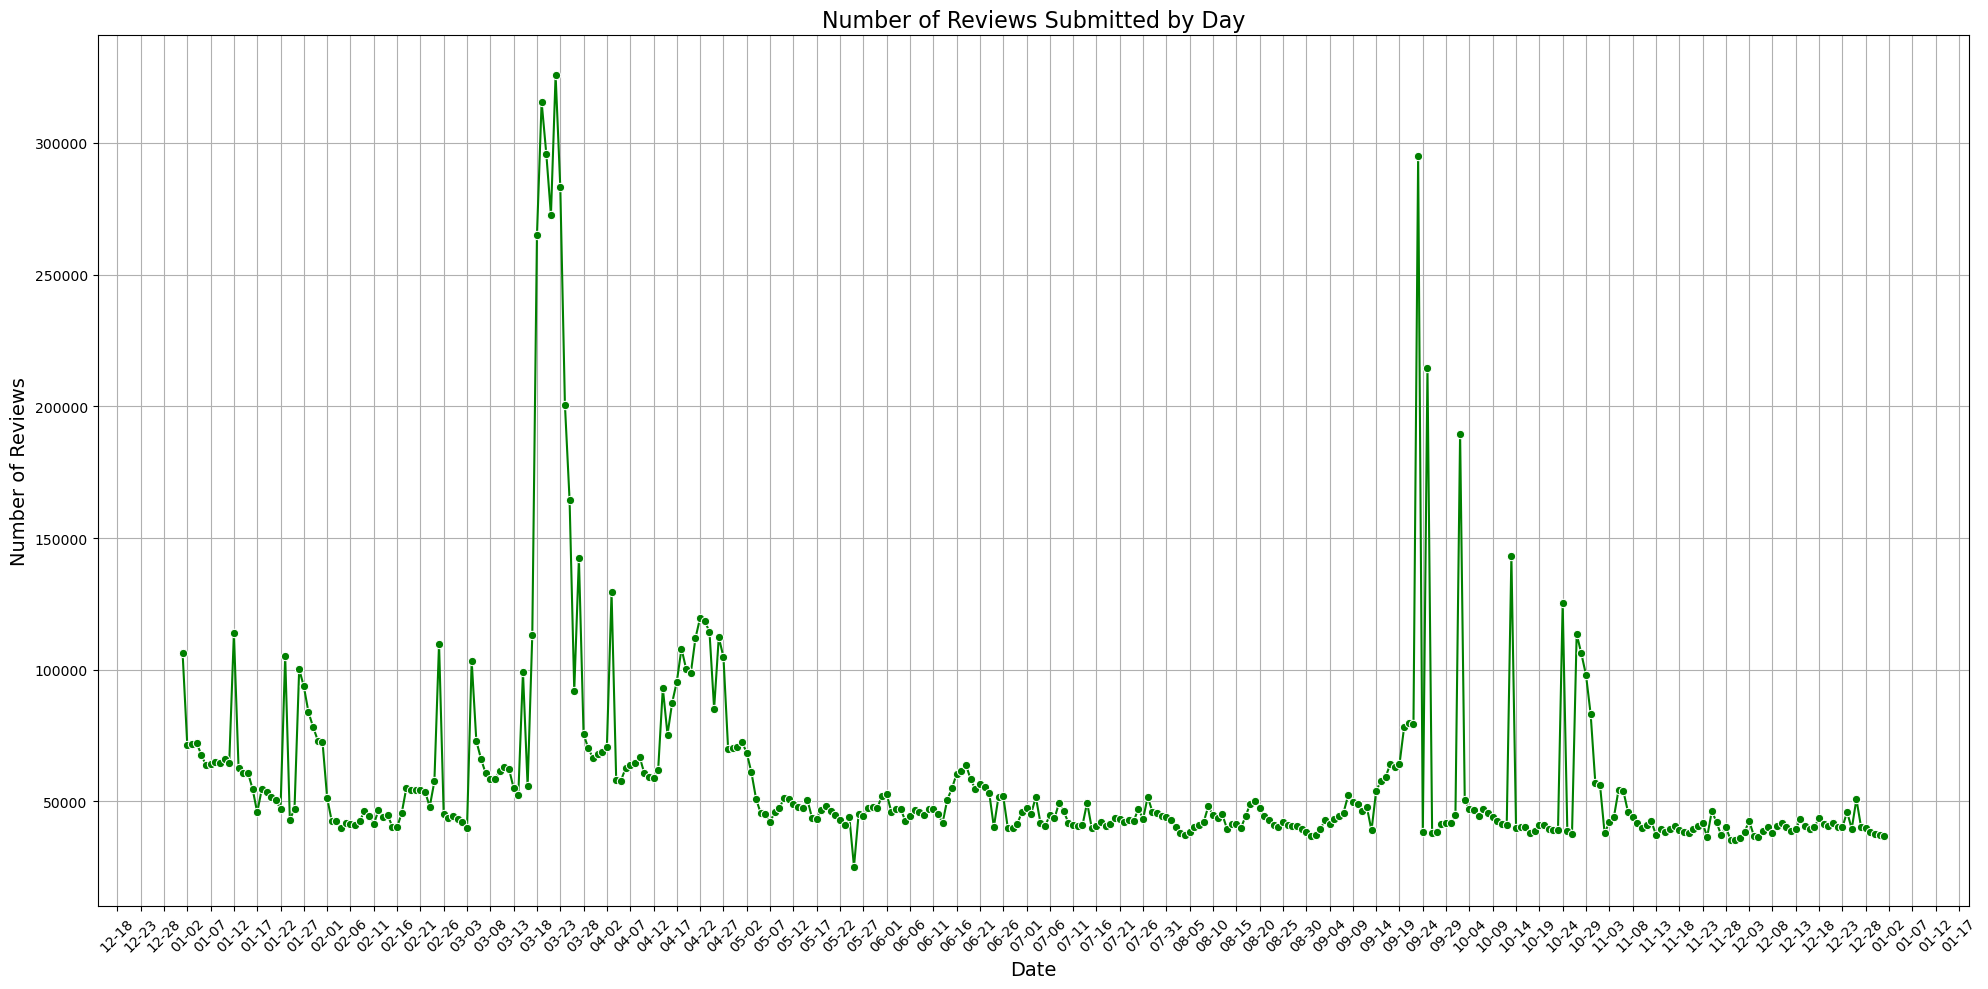

In [1051]:
month_day_num_review_df=month_day_num_review_df.groupby(['month_day_created']).agg(num_review=('num_review','sum')
                                        ).reset_index()
plt.figure(figsize=(20, 10))
sns.lineplot(data=month_day_num_review_df, x='month_day_created', y='num_review', marker='o', color='green')
plt.title('Number of Reviews Submitted by Day', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45) 
# Reduce frequency of x-axis labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show every 5 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.grid(True)
plt.tight_layout()
plt.show()

- What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis.


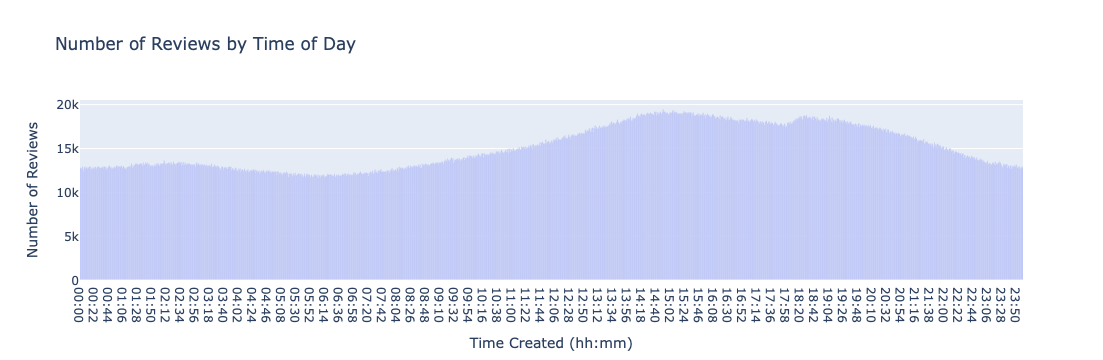

In [1054]:
time_num_review_df=time_num_review_df.groupby(['time_created']).agg(num_review=('num_review','sum')
                                               ).reset_index()

fig = px.bar(time_num_review_df, 
             x='time_created', 
             y='num_review', 
             labels={'time_created': 'Time Created (hh:mm)', 'num_review': 'Number of Reviews'},
             title='Number of Reviews by Time of Day',
             hover_data={'time_created': True, 'num_review': True})  # Enable tooltips

fig.show()

The analysis indicates that users most commonly write reviews between 14:00 and 21:00. This time distribution could suggest that users are more active in engaging with apps during the afternoon and evening, possibly due to increased leisure time after work or school.

- Create a function that accepts a list of time intervals and plots the number of reviews for each interval.

The function created is named <strong>plot_reviews_by_intervals</strong>. It accepts three parameters: df, time_column, and interval (list of tuples), which indicate the column on which the interval analysis is applied in the DataFrame.

In [1059]:
def plot_reviews_by_intervals(df, time_column, intervals):
    # Convert intervals to datetime.time objects for flexibility
    interval_ranges = {}
    for start_time_str, end_time_str in intervals:
        start_time = datetime.strptime(start_time_str, "%H:%M:%S").time()
        end_time = datetime.strptime(end_time_str, "%H:%M:%S").time()
        interval_label = f"{start_time_str} -{end_time_str}"
        interval_ranges[interval_label] = (start_time, end_time)

    # Create a dictionary to count reviews for each interval
    review_counts = {interval: 0 for interval in interval_ranges.keys()}

    # Categorize each review time
    for review_time in df[time_column]:
        
        review_time_only = review_time.time()  # Get time only
        for interval, (start, end) in interval_ranges.items():
            # Intervals that cross midnight
            if start <= end:
                if start <=review_time_only <= end:
                    review_counts[interval]+=1
                    break
            
            else:  # Interval crosses midnight (for instance 23:00 - 02:59)
                if review_time_only >= start or review_time_only <= end:
                    review_counts[interval]+=1
                    break

    # Plot the results
    plt.figure(figsize=(10, 6))
    bars = plt.bar(review_counts.keys(), review_counts.values(), color='skyblue')
    plt.xlabel('Time Interval')
    plt.ylabel('Number of Reviews')
    
    plt.title('Number of Reviews by Time Interval')
    plt.xticks(rotation=45)
    plt.tight_layout()
        # Add value labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

    plt.show()

- Use the function to plot the number of reviews for the following time intervals:

| Initial Time | Final Time |
|--------------|------------|
| 00:00:00     | 02:59:59   |
| 03:00:00     | 05:59:59   |
| 06:00:00     | 10:59:59   |
| 11:00:00     | 13:59:59   |
| 14:00:00     | 16:59:59   |
| 17:00:00     | 19:59:59   |
| 20:00:00     | 23:59:59   |

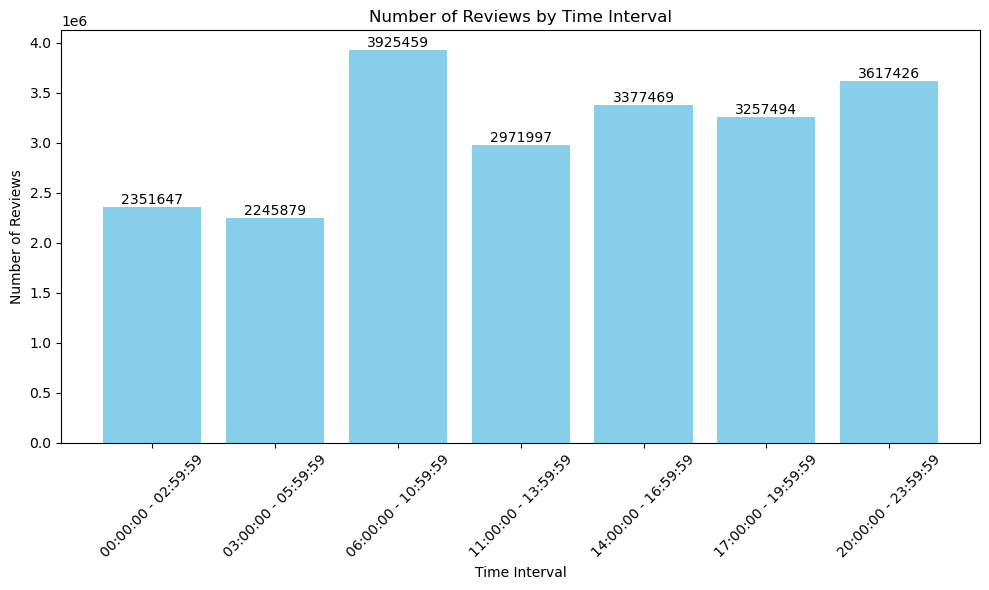

In [1064]:
# Define custom intervals
intervals = [
    ('00:00:00', '02:59:59'),
    ('03:00:00', '05:59:59'),
    ('06:00:00', '10:59:59'),
    ('11:00:00', '13:59:59'),
    ('14:00:00', '16:59:59'),
    ('17:00:00', '19:59:59'),
    ('20:00:00', '23:59:59')
]

plot_reviews_by_intervals(date_time_df, 'datetime_created', intervals)

   - Summarize your findings from the time interval analysis.

From the time interval analysis, we observe that the period between 06:00:00 and 10:59:59 has the highest number of reviews. Conversely, the interval between 00:00:00 and 05:59:00 shows the lowest number of reviews, which could be attributed to users sleeping during these hours.

4. [**RQ4**] *Investigating whether users who spend more time using an application give higher or lower ratings.*

   - Analyze the relationship between the amount of time a user has spent on an application and their review score.

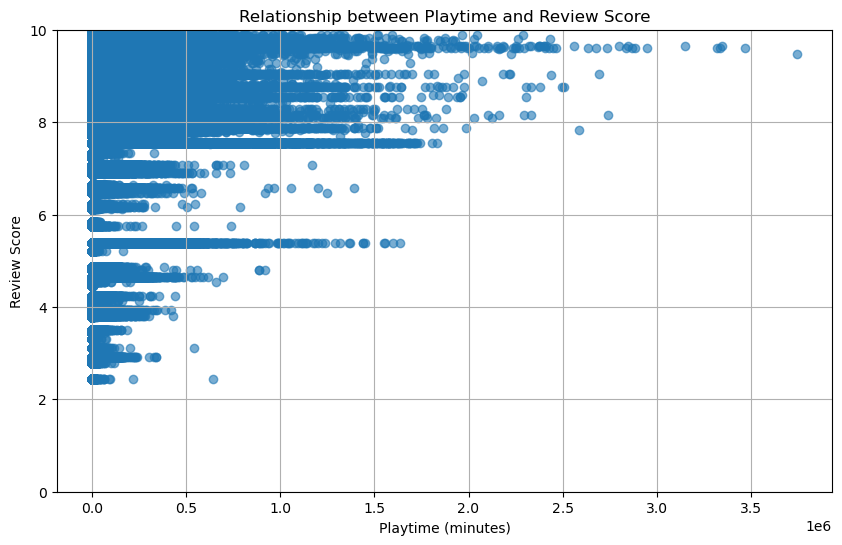

In [1074]:
player_game_playtime_df=player_game_playtime_df.groupby(['author.steamid','app_name']).agg(playtime=('playtime','max')
                                                   ).reset_index().sort_values(by='playtime', ascending=False)
appname_reviewscore_dict = num_review_df.set_index('app_name')['review_score'].to_dict()

player_game_playtime_df['review_score']=player_game_playtime_df['app_name'].map(appname_reviewscore_dict)
# Ensure that review_score is treated as a numeric type
player_game_playtime_df['review_score'] = pd.to_numeric(player_game_playtime_df['review_score'], errors='coerce')

plt.figure(figsize=(10, 6))
plt.scatter(player_game_playtime_df['playtime'], player_game_playtime_df['review_score'], alpha=0.6)
plt.title('Relationship between Playtime and Review Score')
plt.xlabel('Playtime (minutes)')
plt.ylabel('Review Score')
plt.grid(True)
plt.ylim(0, 10)  # Assuming the review score is on a scale from 0 to 10
plt.show()

The analysis shows that users who spend more time in an application are more likely to leave positive reviews and recommend the app. This trend suggests that extended engagement often correlates with user satisfaction, as those who enjoy the experience tend to spend more time and leave favorable feedback. Meanwhile, users with less playtime tend to leave more varied reviews, as first impressions of a game can differ from user to user.

 - Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.

In [1088]:
good_review_by_experienced_player_df= player_preference_df.loc[player_preference_df['seniority'] == 'veteran user']
print("Printing the percentage of positive reviews (recommendations for the game) given by experienced users.")
good_review_by_experienced_player=good_review_by_experienced_player_df['recommended'].sum()/len(good_review_by_experienced_player_df)
print("percentage of positive reviews: ",f"{good_review_by_experienced_player* 100:.2f}%")

Printing the percentage of positive reviews (recommendations for the game) given by experienced users.
percentage of positive reviews:  81.83%


The analysis shows that users who spend more time in an application are more likely to leave positive reviews and recommend the app. This trend suggests that extended gameplay time often indicates user satisfaction, as those who enjoy the experience tend to spend more time and leave favorable feedback.

   - Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.


Since it is not possible to provide a specific numerical review score on steam, this metric is calculated as the ratio of recommendations to the total number of reviews. Accordingly, we will analyze how users with different experience levels recommend the game.

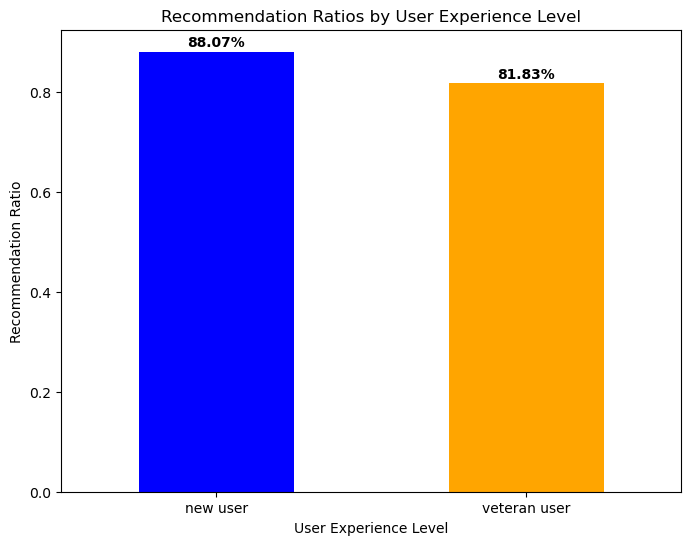

Performing statistical test
p-value equals to: 0.834888029637264
No significant difference in recommendation rates between new and veteran users (p >= 0.05)


In [1084]:
recommendation_count_df = player_preference_df[player_preference_df['recommended'] == True].groupby('seniority').size()
# Calculate total preference counts for each user group
total_preference_count_df = player_preference_df.groupby('seniority').size()
# Calculate recommendation ratios
recommendation_ratio_df = recommendation_count_df / total_preference_count_df
# Plot recommendation ratios for new vs veteran users
ax = recommendation_ratio_df.plot(kind='bar', color=['blue', 'orange'], figsize=(8, 6))
plt.title('Recommendation Ratios by User Experience Level')
plt.xlabel('User Experience Level')
plt.ylabel('Recommendation Ratio')
plt.xticks(rotation=0)

# Adding value labels on top of bars
for i, v in enumerate(recommendation_ratio_df):
    ax.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', fontweight='bold')

plt.show()
print("Performing statistical test")
# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print("p-value equals to:",p_value)
# Verify the results
alpha = 0.05
if p_value < alpha:
    print("Significant difference in recommendation rates between new and veteran users (p < 0.05)")
else:
    print("No significant difference in recommendation rates between new and veteran users (p >= 0.05)")

As shown in the previous analysis, there is no statistically significant difference between user experience levels, as confirmed by the calculated p-value, given a significance threshold of 0.05.

   - Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?


We asked ChatGPT to interpret the statistical results of the analysis and provide explanations for the trends. It confirmed that there is no significant difference in the recommendation ratios between new and veteran users. This suggests that the majority of users who left a review also recommended the game, regardless of their "seniority". ChatGPT then suggested several potential explanations for the observed similarity, including:

- Similar User Experience
- Effective Recommendation System
- Sample Size
- User Engagement
- External Factors
- Variability in User Preferences
<br>

Since the initial analysis did not reveal a significant difference between the two user categories, the suggestions focus on explaining the reasons for the similarity in this distribution rather than differences. These hypotheses can be tested with further analysis using data from the dataset. For example, as suggested, we can assess the sample size to ensure that the dataset is robust enough to provide meaningful insights. 